In [2]:
# Идеи: проблема с категориальными фичами в беггинге и бустинге, сделать пайплайн двухстадийного обучения, чтобы категории превратить в числа 
# или даже взять эмбеддинги от нейросети
# Попробовать LightGBM
# Обучить модель для заполнения пропусков в данных
# Готовая к интеграции в микросервисную архитектуру быстрая модель, где я показываю как жертвую теми или иными признаками чтобы достичь ускорения
# OHE где все нули соответствуют пропуску
# модель готовая к работе в продакшене, где любые значения признаков могут быть неизвестны
# производить отбор признаков по критерию скорости выполнения модели пока не будет достигнута необходимая скорость
# выбрать несколько статистик, относительнокаждой сформировать отсртированный список, посчитать среднее место каждой фичи и на основании уже этой статистики выбрать фичи
# делать фичи при помощи кластеризации и бустить свою морждель

# готовность модели к пропуску в любой фиче для инференса
# CatBoost, LightGBM, LSTM, RNN, нейросетевые методы
# Если при использовании GBDT мы будем обрабатывать категориальные признаки с помощью OHE то получим сильно разреженную матрицу.
# Что создаст проблемы при обучении, это особенность GBDT. Предлагается использовать двухстадийное обучение, а именно сначала сжать 
# категориальные признаки в числовую характеристику с использоваением CatBoost подав ему на вход только категориальные фичи или
# сделать полноценный Stacking подав ему на вход все данные, а OOF результат подать на вход второй модели.
# Сделать оба пайплайна и сравнить результаты.
# online learning и дообучение
# BetaCAalibration на OOF обучении на манер CalibratedClassifierCV


In [3]:
import sys
print(sys.executable)

c:\Users\user\Documents\GitHub\public\.venv\Scripts\python.exe


In [4]:
import os

N_THREADS = 1

os.environ["OMP_NUM_THREADS"] = f"{N_THREADS}"
os.environ["OPENBLAS_NUM_THREADS"] = f"{N_THREADS}"
os.environ["MKL_NUM_THREADS"] = f"{N_THREADS}"
os.environ["VECLIB_MAXIMUM_THREADS"] = f"{N_THREADS}"
os.environ["NUMEXPR_NUM_THREADS"] = f"{N_THREADS}"

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, SplineTransformer, LabelEncoder, OrdinalEncoder
# from pyearth возможно кстати умные сплайны, где я эмпирически буду указвать промежутки 
# будут работать лучше чем обычная модель, в сравнении с равномерно распредленными сплайнами, 
# но опять же это не очень целесообразно, когда та же нелинейность есть в ансамблях решающих деревьев
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import xgboost as xgb
import optuna


import warnings
warnings.filterwarnings('ignore')
# import sklearn
# sklearn.set_config(transform_output='pandas')

c:\Users\user\Documents\GitHub\public\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw03-EDA-data/german_credit.csv", na_values='none')
display(data.head(5).transpose())
data.shape

,0,1,2,3,4
status,no checking account,no checking account,... < 0 DM,no checking account,no checking account
duration,18,9,12,12,12
credit_history,all credits at this bank paid back duly,all credits at this bank paid back duly,no credits taken/all credits paid back duly,all credits at this bank paid back duly,all credits at this bank paid back duly
purpose,car (used),others,retraining,others,others
amount,1049,2799,841,2122,2171
savings,unknown/no savings account,unknown/no savings account,... < 100 DM,unknown/no savings account,unknown/no savings account
employment_duration,< 1 yr,1 <= ... < 4 yrs,4 <= ... < 7 yrs,1 <= ... < 4 yrs,1 <= ... < 4 yrs
installment_rate,< 20,25 <= ... < 35,25 <= ... < 35,20 <= ... < 25,< 20
personal_status_sex,female : non-single or male : single,male : married/widowed,female : non-single or male : single,male : married/widowed,male : married/widowed
other_debtors,NaN,NaN,NaN,NaN,NaN


(1000, 21)

In [5]:
X = data.drop('credit_risk', axis=1)
y = data['credit_risk']

num_cols = ['duration', 'amount', 'age']
cat_cols = [i for i in X.columns if i not in num_cols]

# num_mask = X.columns.isin(num_cols)
# cat_mask = ~num_mask

# num_index = [i for i in range(len(num_mask)) if num_mask[i] == True]
# cat_index = [i for i in range(len(num_mask)) if num_mask[i] == False]

In [6]:
y = y.map({'bad': 0, 'good': 1})
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42, test_size=0.2)

In [7]:
pre_smotenc_pipe = ColumnTransformer([
    ('num_passthrough', 'passthrough', num_cols),
    ('ordinal_encoder', Pipeline([('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), cat_cols)
], verbose_feature_names_out=False).set_output(transform='pandas')

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('OHE', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pre_clf_pipe = ColumnTransformer([
    ('drop_columns', 'drop', ['other_debtors', 'other_installment_plans']),
    ('num_pipe', num_pipe, num_cols),
    ('cat_pipe', cat_pipe, cat_cols)
])

pipe = ImbPipeline([
    ('pre_smotenc', pre_smotenc_pipe),
    ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42)),
    ('preprocessing', pre_clf_pipe),
    ('model', LogisticRegression())
])

pipe.fit(X, y)
print(classification_report(y, pipe.predict(X)))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62       300
           1       0.85      0.78      0.81       700

    accuracy                           0.75      1000
   macro avg       0.71      0.73      0.72      1000
weighted avg       0.76      0.75      0.75      1000



In [ ]:
# full_param_grid = [
#     {
#         'model':[LogisticRegression()],
#         'smotenc__k_neighbors':list(range(1, 11)),
#         'smotenc__sampling_strategy':[1.0],
#         'model__penalty':['l2'],
#         'model__C':np.linspace(-1, 2, 20)
#     },
#     {
#         'model':[SVC(kernel='linear')],
#         'model__C':np.logspace(-4, 4, 9)
#     },
#     {
#         'model':[SVC(kernel='rbf')],
#         'model__C':np.logspace(-4, 4, 9),
#         'model__gamma':['auto', 'scale', 0.001, 0.01, 0.1, 1, 10]
#     },
#     {
#         'model':[SVC(kernel='poly')],
#         'model__degree':[2, 3, 4, 5],
#         'model__C':np.logspace(-4, 4, 9),
#         'model__gamma':['auto', 'scale', 0.001, 0.01, 0.1],
#         'model__coef0':[0, 1, 10]
#     }
# ]

# logreg_param_grid1 = {
#     'smotenc__k_neighbors': [3, 5, 7],
#     'smotenc__sampling_strategy': [0.5, 0.8, 1.0],
#     'model__penalty': ['l1', 'l2'],
#     'model__C':np.logspace(-6, 2, 9)
#         }

# logreg_param_grid2 = {
#     'smotenc__k_neighbors':list(range(1, 11)),
#     'smotenc__sampling_strategy':np.linspace(0.5, 1, 5),
#     'model__penalty':['l2'],
#     'model__C':np.linspace(-1, 2, 20)
#     }

# logreg_param_grid3 = {
#     'smotenc__k_neighbors':[6],
#     'smotenc__sampling_strategy':[0.75],
#     'model__penalty':['l2'],
#     'model__C':[0.26]
#     }

# svc_param_grid = [
#     {
#         'model':[SVC(kernel='linear')],
#         'model__C':np.logspace(-4, 4, 9)
#     },
#     {
#         'model':[SVC(kernel='rbf')],
#         'model__C':np.logspace(-4, 4, 9),
#         'model__gamma':['auto', 'scale', 0.001, 0.01, 0.1, 1, 10]
#     },
#     {
#         'model':[SVC(kernel='poly')],
#         'model__degree':[2, 3, 4, 5],
#         'model__C':np.logspace(-4, 4, 9),
#         'model__gamma':['auto', 'scale', 0.001, 0.01, 0.1],
#         'model__coef0':[0, 1, 10]
#     }
# ]

# svc_param_grid2 = [
#     {
#         'model':[SVC(kernel='poly')],
#         'model__degree':[2],
#         'model__C':[1000],
#         'model__gamma':[0.001],
#         'model__coef0':[10]
#     }
# ]

# # svc_param_grid3 = [
# #     {
# #         'model':[SVC(kernel='poly')],
# #         'model__degree':[2],
# #         'model__C':np.logspace(2, 4, 5),
# #         'model__gamma':np.logspace(-6, -2, 5),
# #         'model__coef0':np.linspace(5, 25, 5)
# #     }
# # ]

# grid = GridSearchCV(
#     estimator=pipe,
#     param_grid=full_param_grid,
#     scoring='f1_weighted',
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
#     n_jobs=6,
#     verbose=3
# )

# grid.fit(x_train, y_train)

# best_model = grid.best_estimator_
# print('f1-score: ', f1_score(y_test, best_model.predict(x_test), average='weighted'))
# grid.best_params_

Fitting 3 folds for each of 812 candidates, totalling 2436 fits
f1-score:  0.7246323529411766


{'model': SVC(kernel='poly'),
 'model__C': np.float64(1.0),
 'model__coef0': 0,
 'model__degree': 2,
 'model__gamma': 0.1}

In [ ]:
# best_model = grid.best_estimator_
# print(classification_report(y_test, best_model.predict(x_test)))

              precision    recall  f1-score   support

         bad       0.59      0.57      0.58        90
        good       0.82      0.83      0.82       210

    accuracy                           0.75       300
   macro avg       0.70      0.70      0.70       300
weighted avg       0.75      0.75      0.75       300



In [ ]:
# n = 2

In [ ]:
# joblib.dump(full_param_grid, f'pickles/param_grid_{n}.pkl')
# joblib.dump(grid, f'pickles/grid_{n}.pkl')

['pickles/grid_2.pkl']

In [ ]:
# p = joblib.load(f'pickles/param_grid_{n}.pkl')
# g = joblib.load(f'pickles/grid_{n}.pkl')

In [ ]:
# best_model = g.best_estimator_
# print(classification_report(y_test, best_model.predict(x_test)))
# p, g.best_params_

              precision    recall  f1-score   support

         bad       0.59      0.57      0.58        90
        good       0.82      0.83      0.82       210

    accuracy                           0.75       300
   macro avg       0.70      0.70      0.70       300
weighted avg       0.75      0.75      0.75       300



([{'model': [LogisticRegression()],
   'smotenc__k_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
   'smotenc__sampling_strategy': [1.0],
   'model__penalty': ['l2'],
   'model__C': array([-1.        , -0.84210526, -0.68421053, -0.52631579, -0.36842105,
          -0.21052632, -0.05263158,  0.10526316,  0.26315789,  0.42105263,
           0.57894737,  0.73684211,  0.89473684,  1.05263158,  1.21052632,
           1.36842105,  1.52631579,  1.68421053,  1.84210526,  2.        ])},
  {'model': [SVC(kernel='linear')],
   'model__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
          1.e+04])},
  {'model': [SVC()],
   'model__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
          1.e+04]),
   'model__gamma': ['auto', 'scale', 0.001, 0.01, 0.1, 1, 10]},
  {'model': [SVC(kernel='poly')],
   'model__degree': [2, 3, 4, 5],
   'model__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
          1.e+04]),
   'model__g

In [ ]:
# def objective(trial):

#     model_name = trial.suggest_categorical('model', ['logreg', 'linear_svc', 'poly_svc', 'rbf_svc'])

#     if model_name == 'logreg':
#         C = trial.suggest_float('C_1', 0.0000001, 2)
#         penalty = trial.suggest_categorical('penalty',['l2'])
#         # k_neighbors = trial.suggest_int('k_neighbors', 1, 10)        
#         # smotenc_sampling_strategy = trial.suggest_categorical('smotenc_sampling_strategy', [1])
#         model = LogisticRegression(penalty=penalty, C=C)
#     elif model_name == 'linear_svc':
#         C = trial.suggest_float('C_2', 0.0001, 1000, log=True)
#         model = SVC(kernel='linear', C=C)
#     elif model_name == 'rbf_svc':
#         C = trial.suggest_float('C_3', 0.0001, 1000, log=True)
#         gamma = trial.suggest_categorical('gamma_category_1', ['auto', 'scale', 'numeric_by_optuna'])
#         if gamma == 'numeric_by_optuna':
#             gamma = trial.suggest_float('gamma_number_1', 0.001, 10, log=True)
#         model = SVC(kernel='rbf', C=C, gamma=gamma)
#     elif model_name == 'poly_svc':
#         degree = trial.suggest_int('degree', 2, 5)
#         C = trial.suggest_float('C_4', 0.0001, 1000, log=True)
#         gamma = trial.suggest_categorical('gamma_category_2', ['auto', 'scale', 'numeric_by_optuna'])
#         if gamma == 'numeric_by_optuna':
#             gamma = trial.suggest_float('gamma_number_2', 0.001, 0.1, log=True)
#         coef0 = trial.suggest_categorical('coef0', [0, 1, 10])
#         # coef0 = trial.suggest_float('coef0', 0, 10)
#         model = SVC(kernel='poly', degree=degree, C=C, gamma=gamma, coef0=coef0)
#     else:
#         pass

#     pipe = ImbPipeline([
#         ('pre_smotenc', pre_smotenc_pipe),
#         ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42, k_neighbors=6, sampling_strategy=0.75)),
#         ('preprocessing', pre_clf_pipe),
#         ('model', model)
#     ])

    
#     score = cross_val_score(estimator=pipe, cv=5, X=x_train, y=y_train, scoring='f1_weighted', n_jobs=12).mean()

#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=400, n_jobs=1)

[I 2025-09-13 15:40:26,320] A new study created in memory with name: no-name-f79c9685-f04a-4235-a2b3-9ee80f40fe5c
[I 2025-09-13 15:40:28,699] Trial 0 finished with value: 0.7327753429760916 and parameters: {'model': 'logreg', 'C_1': 0.2860445311257584, 'penalty': 'l2'}. Best is trial 0 with value: 0.7327753429760916.
[I 2025-09-13 15:40:30,663] Trial 1 finished with value: 0.732684096683972 and parameters: {'model': 'logreg', 'C_1': 0.20081509989274282, 'penalty': 'l2'}. Best is trial 0 with value: 0.7327753429760916.
[I 2025-09-13 15:40:32,385] Trial 2 finished with value: 0.7338874427898159 and parameters: {'model': 'logreg', 'C_1': 0.5411180858315651, 'penalty': 'l2'}. Best is trial 2 with value: 0.7338874427898159.
[I 2025-09-13 15:40:32,581] Trial 3 finished with value: 0.5980537370712421 and parameters: {'model': 'rbf_svc', 'C_3': 0.05402270151206889, 'gamma_category_1': 'scale'}. Best is trial 2 with value: 0.7338874427898159.
[I 2025-09-13 15:40:32,732] Trial 4 finished with va

In [ ]:
# s = 2

In [ ]:
# joblib.dump(study, f'pickles/study_{s}.pkl')

['pickles/stady_1.pkl']

In [ ]:
# study = joblib.load(f'pickles/study_{s}.pkl')

# print(f'Лучшие параметры: {study.best_params}')
# print(f'Лучший f1-weighted: {study.best_value}')

Лучшие параметры: {'model': 'linear_svc', 'C_2': 16.876714407025325}
Лучший f1-weighted: 0.7484678831550631


In [ ]:
# pipe = ImbPipeline([
#     ('pre_smotenc', pre_smotenc_pipe),
#     ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42)),
#     ('preprocessing', pre_clf_pipe),
#     ('model', RandomForestClassifier(random_state=42))
# ])

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# print(cross_val_score(estimator=pipe, X=x_train, y=y_train, scoring='f1_weighted', n_jobs=2, cv=cv).mean())

0.7393401708939781


In [ ]:
# # pipe = ImbPipeline([
# #     ('pre_smotenc', pre_smotenc_pipe),
# #     ('smotenc', SMOTENC(categorical_features=cat_index, random_state=42)),
# #     ('preprocessing', pre_clf_pipe),
# #     ('model', RandomForestClassifier())
# # ])
# # pipe.fit(x_test, y_test)
# # print(f1_score(y_train, pipe.predict(x_train), average='weighted'))

# def objective(trial):

#     n_estimators = trial.suggest_int('n_estimators', 100, 1000)
#     max_depth = trial.suggest_int('max_depth', 5, 50)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.6, 0.7, 0.8, 0.9, None])
#     min_samples_split = 2 #trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = 1 #trial.suggest_int('min_samples_leaf', 1, 10)
#     bootstrap =  True
#     max_samples = 0.5

#     model = RandomForestClassifier(
#         random_state=42, 
#         n_estimators=n_estimators, 
#         max_depth=max_depth, 
#         max_features=max_features,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         bootstrap=bootstrap,
#         max_samples=max_samples
#         )
    
#     pipe = ImbPipeline([
#         ('pre_smotenc', pre_smotenc_pipe),
#         ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42)),
#         ('preprocessing', pre_clf_pipe),
#         ('model', model)
#     ])
    
#     cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     score = cross_val_score(estimator=pipe, X=x_train, y=y_train, scoring='f1_weighted', n_jobs=12, cv=cv).mean()
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200, n_jobs=1)

# print(study.best_params)
# print(study.best_value)


[I 2025-09-13 15:35:46,615] A new study created in memory with name: no-name-6853d2e5-9a04-4200-864e-4c251035673a
[I 2025-09-13 15:35:49,174] Trial 0 finished with value: 0.7489192659608817 and parameters: {'n_estimators': 192, 'max_depth': 49, 'max_features': 0.5}. Best is trial 0 with value: 0.7489192659608817.
[I 2025-09-13 15:35:52,722] Trial 1 finished with value: 0.7342749073981576 and parameters: {'n_estimators': 961, 'max_depth': 18, 'max_features': 0.7}. Best is trial 0 with value: 0.7489192659608817.
[I 2025-09-13 15:35:55,577] Trial 2 finished with value: 0.7403627633756372 and parameters: {'n_estimators': 603, 'max_depth': 25, 'max_features': 0.7}. Best is trial 0 with value: 0.7489192659608817.
[I 2025-09-13 15:35:57,433] Trial 3 finished with value: 0.7375852193066071 and parameters: {'n_estimators': 120, 'max_depth': 37, 'max_features': 'log2'}. Best is trial 0 with value: 0.7489192659608817.
[I 2025-09-13 15:35:57,868] Trial 4 finished with value: 0.7216672452909698 and

{'n_estimators': 312, 'max_depth': 49, 'max_features': 0.5}
0.7531567345207469


In [ ]:
# s=2
# joblib.dump(study, f'pickles/study_{s}.pkl')

['pickles/study_2.pkl']

In [ ]:
# from xgboost import XGBClassifier
# # y_train = y_train
# pipe = ImbPipeline([
#     ('pre_smotenc', pre_smotenc_pipe),
#     ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42)),
#     ('preprocessing', pre_clf_pipe),
#     ('model', XGBClassifier())
# ])

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# print(cross_val_score(estimator=pipe, X=x_train, y=y_train, scoring='f1_weighted', n_jobs=2, cv=cv).mean())

0.7408257311185175


In [ ]:
# from xgboost import XGBClassifier

# def objective(trial):

#     n_estimators = trial.suggest_int('n_estimators', 100, 2000)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
#     subsample = trial.suggest_float('subsample', 0.5, 1)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1)
#     gamma = trial.suggest_int('gamma', 0, 5)
#     reg_lambda = trial.suggest_int('reg_lambda', 0, 10)
#     reg_alpha = trial.suggest_int('reg_alpha', 0, 10)
#     booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])

#     model = XGBClassifier(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         min_child_weight=min_child_weight,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         gamma=gamma,
#         reg_lambda=reg_lambda,
#         reg_alpha=reg_alpha,
#         booster=booster,
#         early_stopping_rounds=30,
#         eval_metric='logloss'
#         )
    
#     pipe = ImbPipeline([
#         ('pre_smotenc', pre_smotenc_pipe),
#         ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42)),
#         ('preprocessing', pre_clf_pipe),
#         ('model', model)
#     ])
    
#     cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     score = []
#     for train_idx, val_idx in cv.split(x_train, y_train):
#         x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
#         x_val, y_val = x_train.iloc[val_idx], y_train.iloc[val_idx]

#         val_pipe = Pipeline([
#             ('pre_smotenc', pre_smotenc_pipe),
#             ('preprocessing', pre_clf_pipe)
#         ])

#         val_pipe.fit(x_tr)
#         x_val_transformed = val_pipe.transform(x_val)

#         pipe.fit(
#             x_tr, y_tr,
#             **{
#                 'model__eval_set':[(x_val_transformed, y_val)],
#                 'model__verbose':False
#             }
#         )

#         score.append(f1_score(y_val, pipe.named_steps['model'].predict(x_val_transformed), average='weighted'))

#     return np.mean(score)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200, n_jobs=6)

[I 2025-09-13 15:25:15,668] A new study created in memory with name: no-name-58624e8b-0c1c-4b46-be90-f323d3ced5a5
[I 2025-09-13 15:25:17,551] Trial 5 finished with value: 0.7228593628612124 and parameters: {'n_estimators': 738, 'learning_rate': 0.2513922490588273, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5518074295218787, 'colsample_bytree': 0.8708715375299825, 'gamma': 2, 'reg_lambda': 9, 'reg_alpha': 2, 'booster': 'gbtree'}. Best is trial 5 with value: 0.7228593628612124.
[I 2025-09-13 15:25:18,309] Trial 2 finished with value: 0.7193433983001944 and parameters: {'n_estimators': 383, 'learning_rate': 0.026391946765167117, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.881978007983318, 'colsample_bytree': 0.7997786253878196, 'gamma': 5, 'reg_lambda': 10, 'reg_alpha': 4, 'booster': 'gbtree'}. Best is trial 5 with value: 0.7228593628612124.
[I 2025-09-13 15:25:19,089] Trial 1 finished with value: 0.7386636174530975 and parameters: {'n_estimators': 1846, 'learning_rat

In [8]:
# [I 2025-09-13 15:41:29,064] Trial 255 finished with value: 0.7362976516666443 and parameters: {'model': 'logreg', 'C_1': 0.23350195577056704, 'penalty': 'l2'}. Best is trial 255 with value: 0.7362976516666443.

logreg_best_model_pipe = ImbPipeline([
    ('pre_smotenc', pre_smotenc_pipe),
    ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42, k_neighbors=6, sampling_strategy=0.75)),
    ('preprocessing', pre_clf_pipe),
    ('model', LogisticRegression(penalty='l2', C=0.23350195577056704))
])

cross_val_score(estimator=logreg_best_model_pipe, cv=5, X=x_train, y=y_train, scoring='f1_weighted', n_jobs=12).mean()

np.float64(0.7362976516666443)

In [ ]:
# [I 2025-09-13 15:37:09,979] Trial 92 finished with value: 0.7531567345207469 and parameters: {'n_estimators': 312, 'max_depth': 49, 'max_features': 0.5}. Best is trial 92 with value: 0.7531567345207469.

# min_samples_split = 2 #trial.suggest_int('min_samples_split', 2, 20)
# min_samples_leaf = 1 #trial.suggest_int('min_samples_leaf', 1, 10)
# bootstrap =  True
# max_samples = 0.5

# model = RandomForestClassifier(
#         random_state=42, 
#         n_estimators=312, 
#         max_depth=49, 
#         max_features=0.5,
#         min_samples_split=2,
#         min_samples_leaf=1,
#         bootstrap=True,
#         max_samples=0.5
#         )

random_forest_best_model_pipe = ImbPipeline([
    ('pre_smotenc', pre_smotenc_pipe),
    ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42)),
    ('preprocessing', pre_clf_pipe),
    ('model', RandomForestClassifier(
        random_state=42, 
        n_estimators=312, 
        max_depth=49, 
        max_features=0.5,
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        max_samples=0.5
        ))
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_val_score(estimator=random_forest_best_model_pipe, X=x_train, y=y_train, scoring='f1_weighted', n_jobs=12, cv=cv).mean()

np.float64(0.7531567345207469)

In [10]:
# [I 2025-09-13 15:29:19,491] Trial 107 finished with value: 0.7581644528850712 and parameters: {'n_estimators': 281, 'learning_rate': 0.0929920030595642, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8752945550232539, 'colsample_bytree': 0.7686511209987077, 'gamma': 0, 'reg_lambda': 7, 'reg_alpha': 3, 'booster': 'gbtree'}. Best is trial 107 with value: 0.7581644528850712.
from xgboost import XGBClassifier

xgb_best_model_pipe = ImbPipeline([
    ('pre_smotenc', pre_smotenc_pipe),
    ('smotenc', SMOTENC(categorical_features=cat_cols, random_state=42)),
    ('preprocessing', pre_clf_pipe),
    ('model', XGBClassifier(
        n_estimators=281,
        learning_rate=0.0929920030595642,
        max_depth=10,
        min_child_weight=1,
        subsample=0.8752945550232539,
        colsample_bytree=0.7686511209987077,
        gamma=0,
        reg_lambda=7,
        reg_alpha=3,
        booster='gbtree',
        # early_stopping_rounds=30,
        eval_metric='logloss'
        ))
])

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# score = []
# for train_idx, val_idx in cv.split(x_train, y_train):
#     x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
#     x_val, y_val = x_train.iloc[val_idx], y_train.iloc[val_idx]

#     val_pipe = Pipeline([
#         ('pre_smotenc', pre_smotenc_pipe),
#         ('preprocessing', pre_clf_pipe)
#     ])

#     val_pipe.fit(x_tr)
#     x_val_transformed = val_pipe.transform(x_val)

#     xgb_best_model_pipe.fit(
#         x_tr, y_tr,
#         **{
#             'model__eval_set':[(x_val_transformed, y_val)],
#             'model__verbose':False
#         }
#     )

#     score.append(f1_score(y_val, xgb_best_model_pipe.named_steps['model'].predict(x_val_transformed), average='weighted'))
# np.mean(score)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_val_score(estimator=xgb_best_model_pipe, X=x_train, y=y_train, scoring='f1_weighted', n_jobs=12, cv=cv).mean()

np.float64(0.7570435060608176)

In [11]:
from sklearn.metrics import log_loss

models: list[str] = ['logreg', 'XGB', 'RandomForest']
y_pred_for_models: dict[str, np.ndarray] = {}

for i in models:
    
    if i == 'logreg':
        logreg_best_model_pipe.fit(x_train, y_train)
        y_pred_for_models[i] = logreg_best_model_pipe.predict_proba(x_test)[:,1]
        
    elif i == 'RandomForest':
        random_forest_best_model_pipe.fit(x_train, y_train)
        y_pred_for_models[i] = random_forest_best_model_pipe.predict_proba(x_test)[:,1]
        
    elif i == 'XGB':
        xgb_best_model_pipe.fit(x_train, y_train)
        y_pred_for_models[i] = xgb_best_model_pipe.predict_proba(x_test)[:,1]

for i in y_pred_for_models.keys():
    print(i)
    print(log_loss(y_test, y_pred_for_models[i]))

logreg
0.4964348076213539
XGB
0.529298345930415
RandomForest
0.5061401559618786


In [12]:
from sklearn.metrics import brier_score_loss

for i in y_pred_for_models.keys():
    print(i)
    print(brier_score_loss(y_test, y_pred_for_models[i]))

logreg
0.16410176091521747
XGB
0.1745835928373417
RandomForest
0.1677977071005917


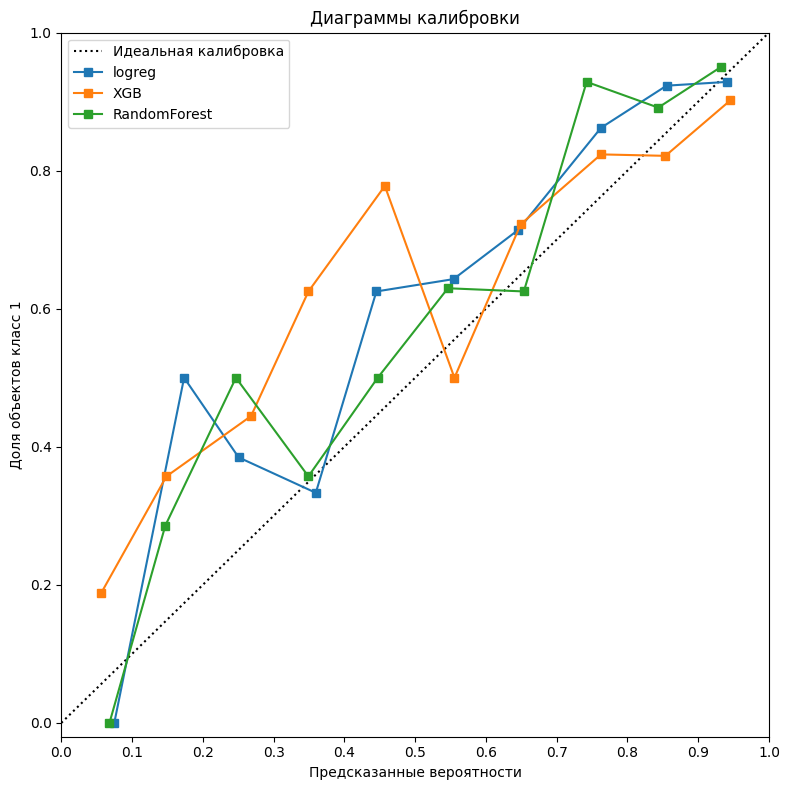

In [13]:
from sklearn.calibration import calibration_curve


fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k:', label='Идеальная калибровка')

for i in y_pred_for_models.keys():
    fraction_of_positivities_y, mean_predicted_value_x = calibration_curve(y_test, y_pred_for_models[i], n_bins=10)
    ax.plot(mean_predicted_value_x, fraction_of_positivities_y, 's-', label=i)

# depict bins
bin_edges = np.linspace(0, 1, 11)
ax.set_xticks(bin_edges)

ax.set_xlim(0, 1)
ax.set_ylim(-0.02, 1)
ax.set_xlabel('Предсказанные вероятности')
ax.set_ylabel('Доля объектов класс 1')
ax.set_title('Диаграммы калибровки')
ax.legend()
fig.tight_layout()
fig.show()

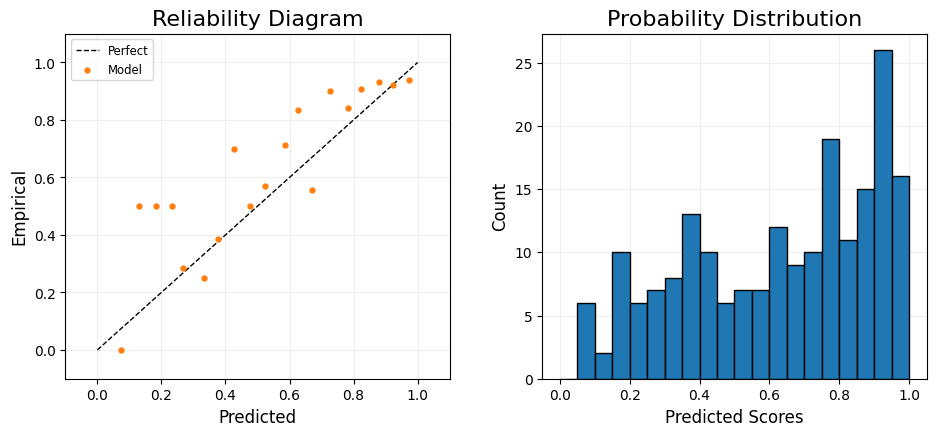

In [14]:
import ml_insights as mli

plt.figure(figsize=(10, 5))
rd = mli.plot_reliability_diagram(y_test, y_pred_for_models['logreg'], show_histogram=True, error_bars=False);

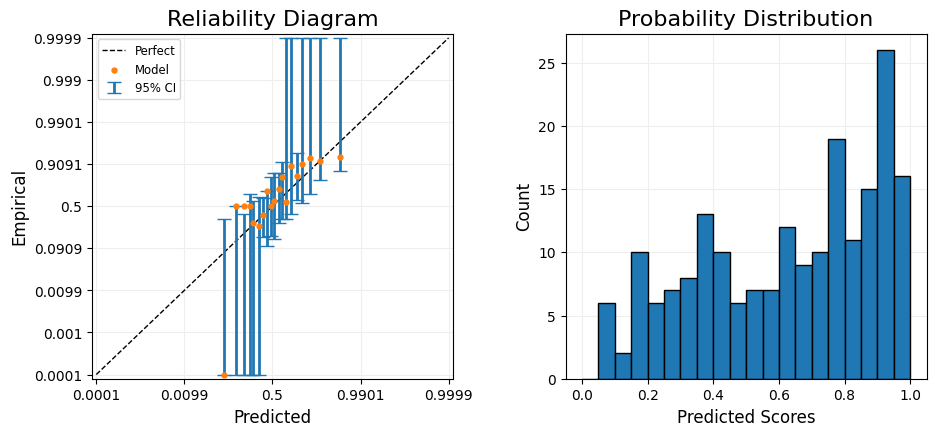

In [15]:
plt.figure(figsize=(10, 5))
rd = mli.plot_reliability_diagram(y_test, y_pred_for_models['logreg'], show_histogram=True, scaling='logit');

In [16]:
from sklearn.isotonic import IsotonicRegression

iso = IsotonicRegression(out_of_bounds='clip')

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2, stratify=y)
x_train, x_calib, y_train, y_calib = train_test_split(x_train, y_train, shuffle=True, random_state=42, test_size=0.3, stratify=y_train)

random_forest_best_model_pipe.fit(x_train, y_train)
y_test_pred_proba = random_forest_best_model_pipe.predict_proba(x_test)[:, 1]
y_calib_pred_proba = random_forest_best_model_pipe.predict_proba(x_calib)[:, 1]

iso.fit(y_calib_pred_proba, y_calib)

y_calib_pred_proba_iso = iso.predict(y_calib_pred_proba)
y_test_pred_proba_iso = iso.predict(y_test_pred_proba)

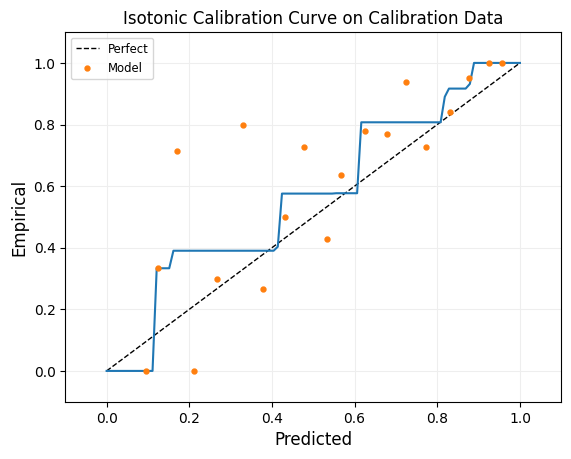

In [17]:
rd = mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False)
tvec = np.linspace(0, 1, 100)
plt.plot(tvec, iso.predict(tvec), label='Isotonic')
plt.title('Isotonic Calibration Curve on Calibration Data')
plt.show()

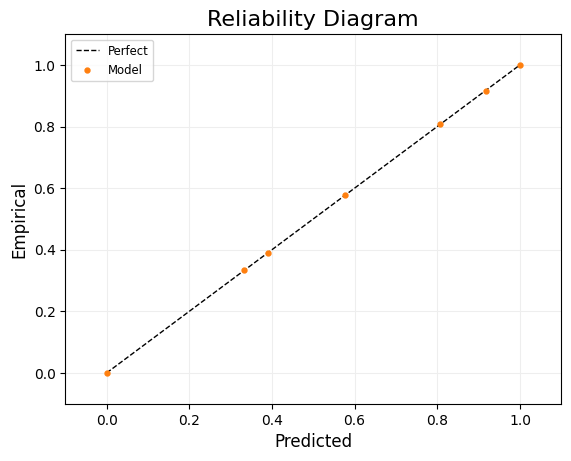

In [18]:
rd = mli.plot_reliability_diagram(y_calib, y_calib_pred_proba_iso, error_bars=False)

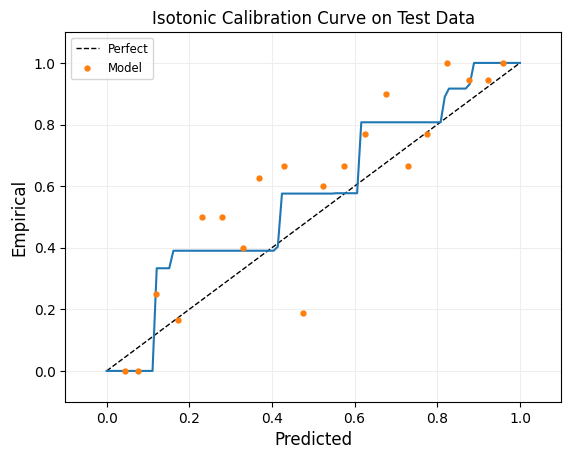

In [19]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False)
tvec = np.linspace(0, 1, 100)
plt.plot(tvec, iso.predict(tvec), label="Isotonic")
plt.title("Isotonic Calibration Curve on Test Data");

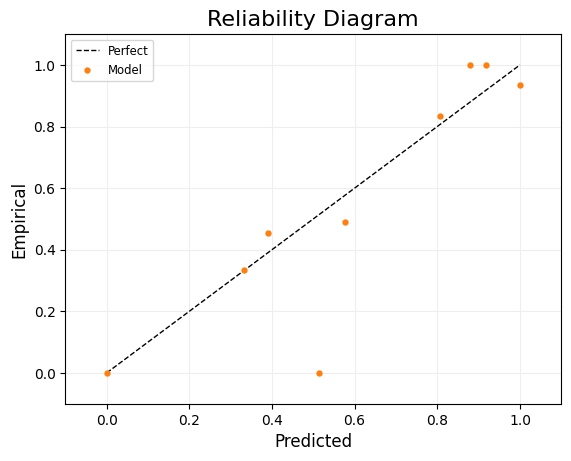

In [20]:
rd = mli.plot_reliability_diagram(y_test, y_test_pred_proba_iso, error_bars=False)

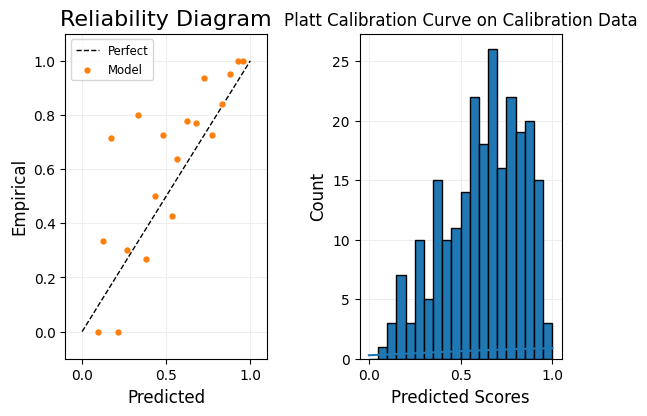

In [21]:
lr = LogisticRegression()
lr.fit(y_calib_pred_proba.reshape(-1, 1), y_calib)

y_calib_pred_proba_platt = lr.predict_proba(y_calib_pred_proba.reshape(-1, 1))[:,1]
y_test_pred_proba_platt = lr.predict_proba(y_test_pred_proba.reshape(-1, 1))[:,1]

rd = mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False, show_histogram=True)
tvec = np.linspace(0, 1, 100)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1, 1))[:,1])
plt.title("Platt Calibration Curve on Calibration Data");

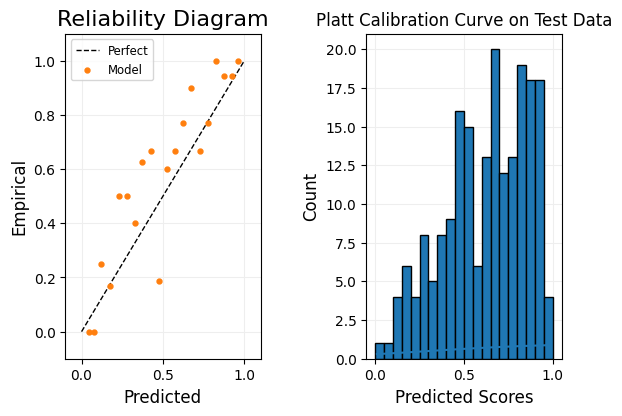

In [22]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False, show_histogram=True)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1, 1))[:, 1])
plt.title("Platt Calibration Curve on Test Data");

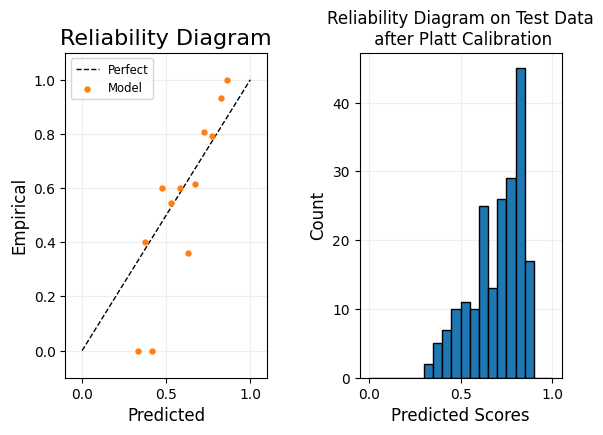

In [23]:
rd = mli.plot_reliability_diagram(y_test, y_test_pred_proba_platt, error_bars=False, show_histogram=True)
plt.title("Reliability Diagram on Test Data\n after Platt Calibration");

In [24]:
print(
    "Platt calibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba_platt))
)
print("Uncalibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba)))

Platt calibrated log_loss = 0.5070879335509771
Uncalibrated log_loss = 0.4984291007036773


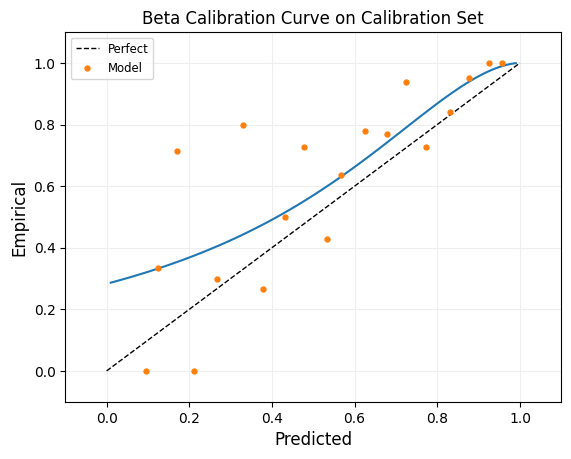

In [25]:
from betacal import BetaCalibration

bc = BetaCalibration()
bc.fit(y_calib_pred_proba, y_calib)
y_calib_pred_proba_bc = bc.predict(y_calib_pred_proba)
y_test_pred_proba_bc = bc.predict(y_test_pred_proba)

mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title("Beta Calibration Curve on Calibration Set");

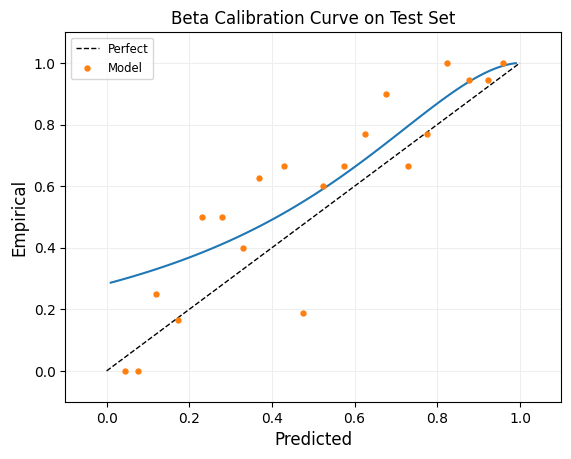

In [26]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title("Beta Calibration Curve on Test Set");

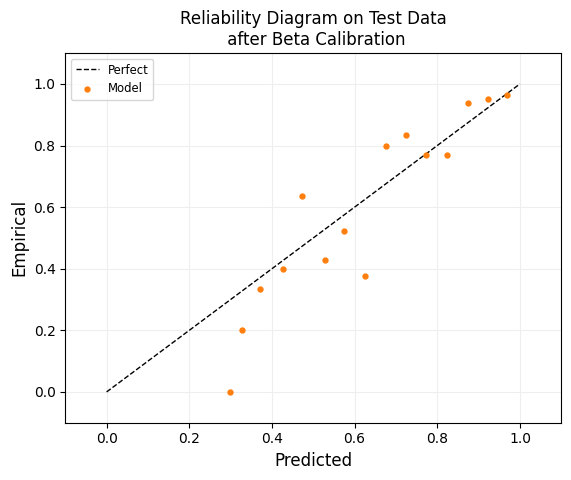

In [27]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba_bc, error_bars=False)
plt.title("Reliability Diagram on Test Data\n after Beta Calibration");

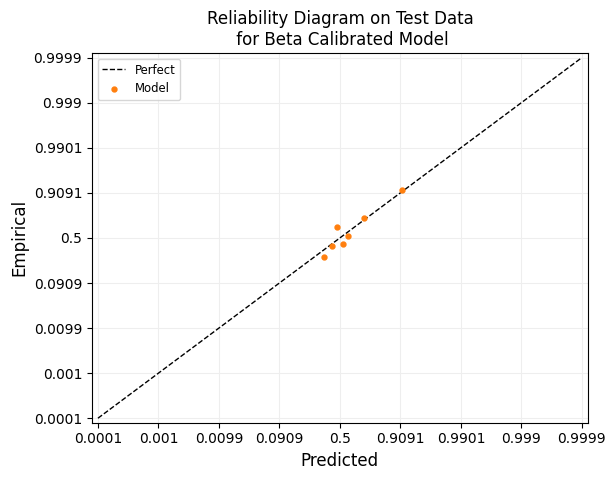

In [28]:
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])
rd = mli.plot_reliability_diagram(
    y_test, y_test_pred_proba_bc, scaling="logit", bins=custom_bins, error_bars=False
)
plt.title("Reliability Diagram on Test Data\n for Beta Calibrated Model");

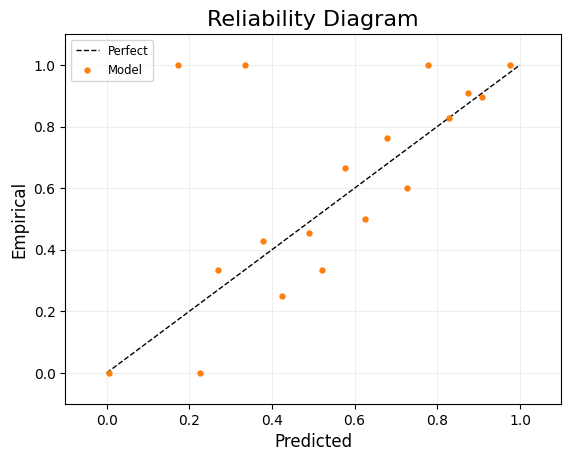

In [29]:
from sklearn.calibration import CalibratedClassifierCV

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, stratify=y, test_size=0.2)

calibrated_lr = CalibratedClassifierCV(estimator=logreg_best_model_pipe, method='isotonic')
calibrated_lr.fit(x_train, y_train)
rd = mli.plot_reliability_diagram(y_test, calibrated_lr.predict_proba(x_test)[:,1], error_bars=False)


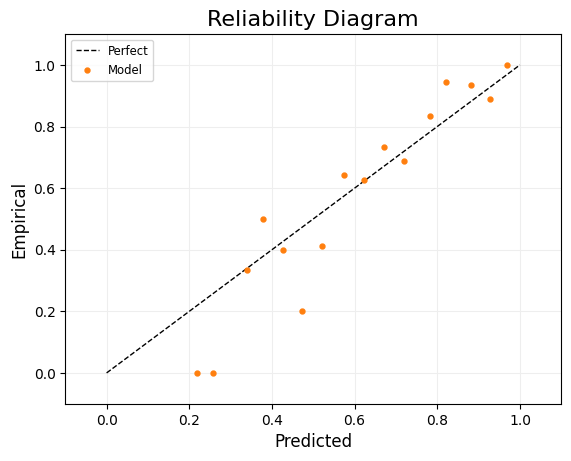

In [30]:
calibrated_platt_lr = CalibratedClassifierCV(estimator=logreg_best_model_pipe, method='sigmoid')
calibrated_platt_lr.fit(x_train, y_train)
rd = mli.plot_reliability_diagram(y_test, calibrated_platt_lr.predict_proba(x_test)[:,1], error_bars=False)

In [31]:
print("Beta calibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba_bc)))
print(
    "Isotonic calibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba_iso))
)
print(
    "Platt calibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba_platt))
)
print("Uncalibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba)))

Beta calibrated log_loss = 0.482047573033643
Isotonic calibrated log_loss = 0.8011227791159428
Platt calibrated log_loss = 0.5070879335509771
Uncalibrated log_loss = 0.4984291007036773


In [32]:
model=logreg_best_model_pipe

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42, test_size=0.2)
x_train, x_calib, y_train, y_calib = train_test_split(x_train, y_train, shuffle=True, stratify=y_train, random_state=42, test_size=0.3)

# model = logreg_best_model_pipe
model.fit(x_train, y_train)
model_predprob_calib = model.predict_proba(x_calib)
model_predprob_test = model.predict_proba(x_test)


platt = LogisticRegression()

if (hasattr(model, 'decision_function')):
    calib_scores = model.decision_function(x_calib).reshape(-1, 1)
    platt.fit(calib_scores, y_calib)

    test_scores = model.decision_function(x_test).reshape(-1, 1)
    platt_test_proba = platt.predict_proba(test_scores)[:,1]
else:
    platt.fit(model_predprob_calib[:,1].reshape(-1, 1), y_calib)
    platt_test_proba = platt.predict(model_predprob_test[:,1].reshape(-1, 1))


In [68]:
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
import torch
from torchmetrics.classification import CalibrationError

def compare_metrics_func(metric_before, metric_after) -> str:
    # val = 0
    res = ''
    distinction = metric_before - metric_after
    if distinction < 0:
        # res = 'after calibration is bigger'
        val = ((distinction) / metric_before) * 100
    else:
        # res = 'after calibration is lower'
        val = ((distinction) / metric_before) * 100
    # return f'{res} on {val}%'
    return val

def metrics_after_calibration(y_true, predprob_before=0, predprob_after=0):
    roc_auc_before = roc_auc_score(y_true, predprob_before)
    roc_auc_after = roc_auc_score(y_true, predprob_after)
    roc_auc_res = compare_metrics_func(roc_auc_before, roc_auc_after)
    # print('roc_auc_score ' + roc_auc_res)

    log_loss_before = log_loss(y_true, predprob_before)
    log_loss_after = log_loss(y_true, predprob_after)
    log_loss_res = compare_metrics_func(log_loss_before, log_loss_after)
    # print('log_loss ' + log_loss_res)

    brier_score_before = brier_score_loss(y_true, predprob_before)
    brier_score_after = brier_score_loss(y_true, predprob_after)
    brier_score_res = compare_metrics_func(brier_score_before, brier_score_after)
    # print('brier_score_loss ' + brier_score_res)

    y_true_t = torch.tensor(np.array(y_true), dtype=torch.long)
    predprob_before_t = torch.tensor(np.array(predprob_before), dtype=torch.float32)
    predprob_after_t = torch.tensor(np.array(predprob_after), dtype=torch.float32)
    calib_error = CalibrationError(task='binary')
    calib_error_before = calib_error(predprob_before_t, y_true_t).item()
    calib_error_after = calib_error(predprob_after_t, y_true_t).item()
    calib_error_res = compare_metrics_func(calib_error_before, calib_error_after)
    # print('CalibrationError ' + calib_error_res)

    return {
            'roc_auc':roc_auc_res, 
            'log_loss':log_loss_res, 
            'brier_score':brier_score_res, 
            'calib_error':calib_error_res
            }




,roc_auc после калибровки,log_loss после калибровки,brier_score после калибровки,calib_error после калибровки
Изотоническая калибровка,1.075751,3.075421,2.685523,51.728445
Калибровка Платта,0.000000,3.042475,4.030748,37.249937
Бета-калибровка,0.000000,3.116133,4.073723,43.279588


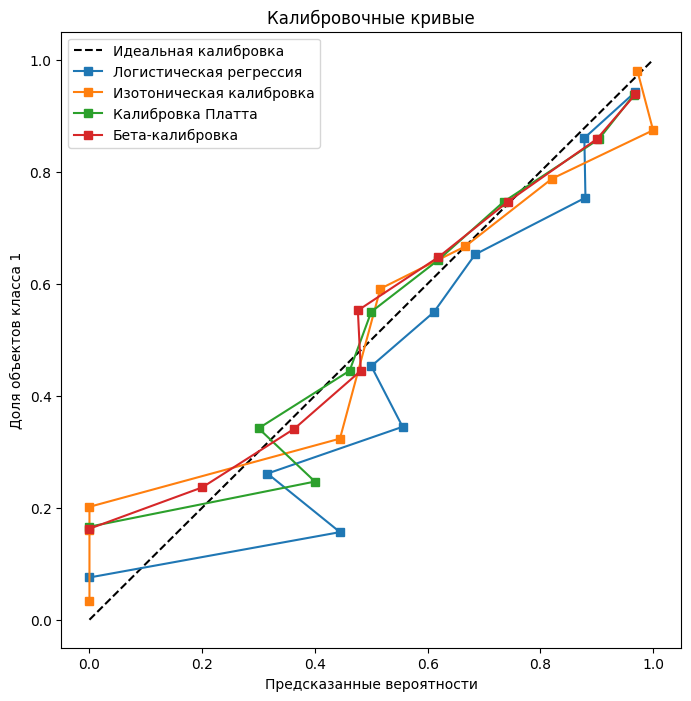

In [ ]:
from IPython.display import display

def depict_ccurves(model, n_bins: int, base_model_name: str) -> None:
    plt.figure(figsize=(8, 8))

    x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42, test_size=0.2)
    x_train, x_calib, y_train, y_calib = train_test_split(x_train, y_train, shuffle=True, stratify=y_train, random_state=42, test_size=0.3)

    # model = logreg_best_model_pipe
    model.fit(x_train, y_train)
    model_predprob_calib = model.predict_proba(x_calib)
    model_predprob_test = model.predict_proba(x_test)

    iso = IsotonicRegression(out_of_bounds='clip').fit(model_predprob_calib[:,1], y_calib)

    platt = LogisticRegression()
    if (hasattr(model, 'decision_function')):
        calib_scores = model.decision_function(x_calib).reshape(-1, 1)
        platt.fit(calib_scores, y_calib)
        test_scores = model.decision_function(x_test).reshape(-1, 1)
        platt_test_proba = platt.predict_proba(test_scores)[:,1]
    else:
        eps = 1e-6
        calib_clipped = np.clip(model_predprob_calib[:,1], eps, 1 - eps)
        test_clipped = np.clip(model_predprob_test[:,1], eps, 1 - eps)
        calib_logits = np.log(calib_clipped / (1 - calib_clipped)).reshape(-1, 1)
        test_logits = np.log(test_clipped / (1 - test_clipped)).reshape(-1, 1)
        platt.fit(calib_logits, y_calib)
        platt_test_proba = platt.predict_proba(test_logits)[:,1]


    beta = BetaCalibration().fit(model_predprob_calib[:,1], y_calib)

    model_metrics = pd.DataFrame(columns=[
        'roc_auc после калибровки', 
        'log_loss после калибровки', 
        'brier_score после калибровки', 
        'calib_error после калибровки'])

    plt.plot([0, 1], [0, 1], '--k', label='Идеальная калибровка')
    true_probability_y, pred_probality_x = calibration_curve(y_test, model_predprob_test[:,1], n_bins=n_bins)
    plt.plot(true_probability_y, pred_probality_x, 's-', label=base_model_name)
    true_probability_y, pred_probality_x = calibration_curve(y_test, iso.predict(model_predprob_test[:,1]), n_bins=n_bins)
    plt.plot(true_probability_y, pred_probality_x, 's-', label='Изотоническая калибровка')
    model_metrics.loc['Изотоническая калибровка'] = metrics_after_calibration(
        y_test, 
        predprob_before=model_predprob_test[:,1], 
        predprob_after=iso.predict(model_predprob_test[:,1])
        ).values()
    true_probability_y, pred_probality_x = calibration_curve(y_test, platt_test_proba, n_bins=n_bins)
    plt.plot(true_probability_y, pred_probality_x, 's-', label='Калибровка Платта')
    model_metrics.loc['Калибровка Платта'] = metrics_after_calibration(
        y_test, 
        predprob_before=model_predprob_test[:,1], 
        predprob_after=platt_test_proba
        ).values()
    true_probability_y, pred_probality_x = calibration_curve(y_test, beta.predict(model_predprob_test[:,1]), n_bins=n_bins)
    plt.plot(true_probability_y, pred_probality_x, 's-', label='Бета-калибровка')
    model_metrics.loc['Бета-калибровка'] = metrics_after_calibration(
        y_test, 
        predprob_before=model_predprob_test[:,1], 
        predprob_after=beta.predict(model_predprob_test[:,1])
        ).values()
    
    display(model_metrics)


    plt.legend()
    plt.title('Калибровочные кривые')
    plt.ylabel('Доля объектов класса 1')
    plt.xlabel('Предсказанные вероятности')

    plt.show()
depict_ccurves(logreg_best_model_pipe, 10, 'Логистическая регрессия')

,roc_auc после калибровки,log_loss после калибровки,brier_score после калибровки,calib_error после калибровки
Изотоническая калибровка,0.879722,-60.729536,3.559166,33.663574
Калибровка Платта,0.000000,2.962818,3.074344,11.075934
Бета-калибровка,0.000000,3.286631,3.198351,22.938280


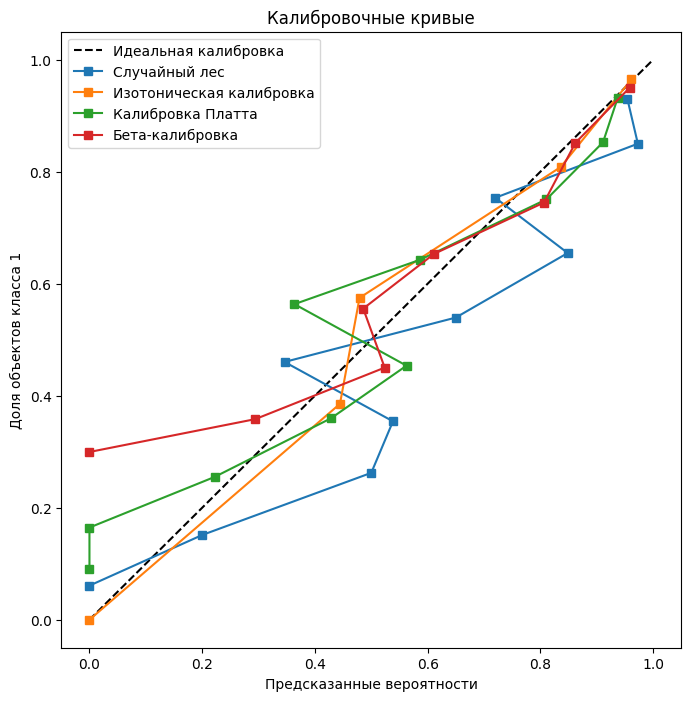

In [79]:
depict_ccurves(random_forest_best_model_pipe, 10, 'Случайный лес')

,roc_auc после калибровки,log_loss после калибровки,brier_score после калибровки,calib_error после калибровки
Изотоническая калибровка,0.617563,-5.285487,7.639903,46.575716
Калибровка Платта,0.000000,4.156124,4.981544,32.615644
Бета-калибровка,0.000000,3.704624,4.466687,45.062270


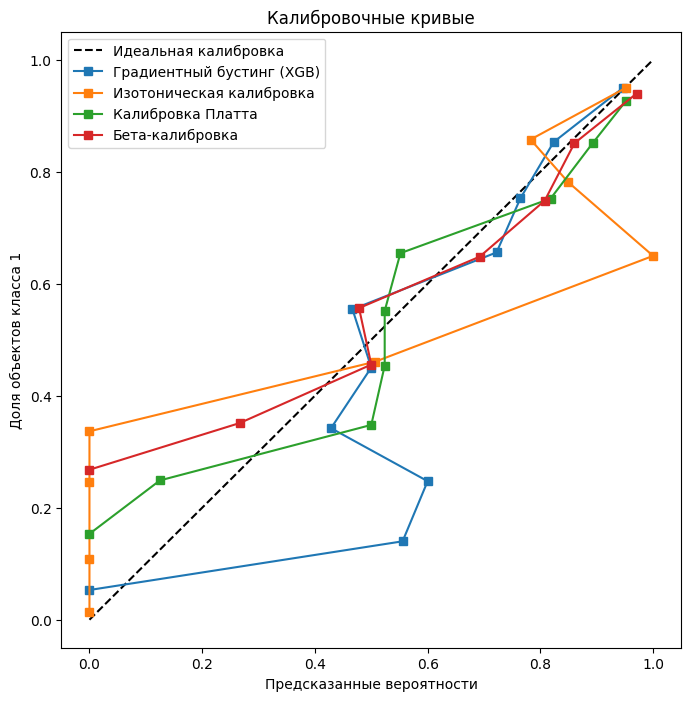

In [80]:
depict_ccurves(xgb_best_model_pipe, 10, 'Градиентный бустинг (XGB)')